In [1]:
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd 
from scipy import stats
import graphviz as gr
from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf
from data_loader import load

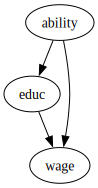

In [2]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g

In [3]:
wage = load("wage.csv").dropna()
wage

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
924,1442,40,3.584907,113,16,8,10,35,1,0,1,1,2,2.0,8.0,8.0
925,645,45,2.662588,93,12,11,3,35,1,0,1,0,7,7.0,7.0,8.0
928,477,45,2.360854,100,12,9,3,31,1,0,1,0,3,3.0,7.0,7.0
929,664,60,2.403938,82,16,10,9,34,1,1,1,1,3,4.0,16.0,16.0


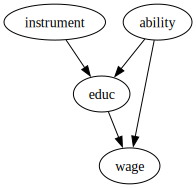

In [4]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("instrument", "educ")
g

Intstrumental Variable IV. Key idea: find variable Z uncorrelated with Y but correlated with T (exclusion restriction.)

Provides a way to deal with ability when we don't have an exact variable for Ability 

Short vs long equation? 

OVB = Cofoundiing bias

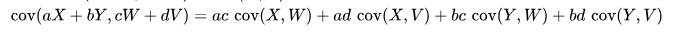

and Cov(Z,v)=0

Then:

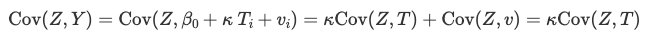

# Back to wages 

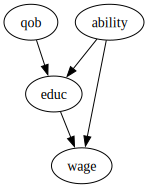

In [5]:
g = gr.Digraph()

g.edge("ability", "educ")
g.edge("ability", "wage")
g.edge("educ", "wage")
g.edge("qob", "educ")
g

In [7]:
data = load("ak91.csv")
data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth
0,5.790019,12.0,30.0,1.0,45.0
1,5.952494,11.0,30.0,1.0,45.0
2,5.315949,12.0,30.0,1.0,45.0
3,5.595926,12.0,30.0,1.0,45.0
4,6.068915,12.0,30.0,1.0,37.0


## Ensure valid IV

- cov(Z,T) != 0 
- Y indendent Z | T (exclusion restriction)

### First verify 1. 

Begin by plotting:

In [8]:
group_data = (data
              .groupby(["year_of_birth", "quarter_of_birth"])
              [["log_wage", "years_of_schooling"]]
              .mean()
              .reset_index()
              .assign(time_of_birth = lambda d: d["year_of_birth"] + (d["quarter_of_birth"])/4))

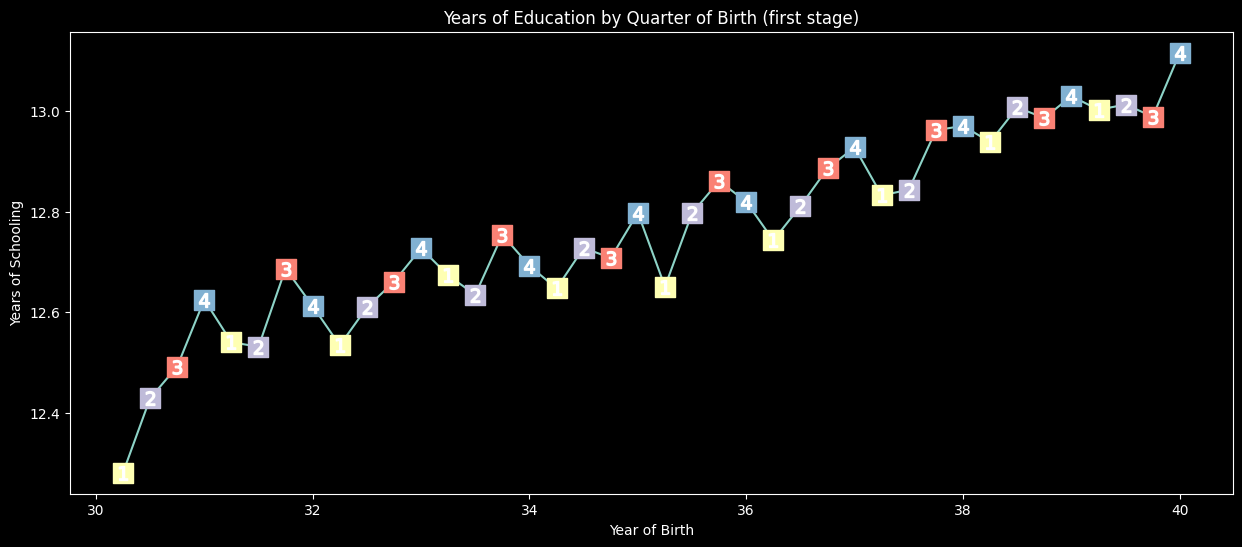

In [9]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["years_of_schooling"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["years_of_schooling"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Years of Education by Quarter of Birth (first stage)")
plt.xlabel("Year of Birth")
plt.ylabel("Years of Schooling");

This first stage can be a linear regression:


In [10]:
# dummy encoding for quarter of birth
factor_data = data.assign(**{f"q{int(q)}": (data["quarter_of_birth"] == q).astype(int)
                             for q in data["quarter_of_birth"].unique()})

factor_data.head()

,log_wage,years_of_schooling,year_of_birth,quarter_of_birth,state_of_birth,q1,q2,q3,q4
0,5.790019,12.0,30.0,1.0,45.0,1,0,0,0
1,5.952494,11.0,30.0,1.0,45.0,1,0,0,0
2,5.315949,12.0,30.0,1.0,45.0,1,0,0,0
3,5.595926,12.0,30.0,1.0,45.0,1,0,0,0
4,6.068915,12.0,30.0,1.0,37.0,1,0,0,0


Start with just the 4th quarter

In [11]:
first_stage = smf.ols("years_of_schooling ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", first_stage.params["q4"])
print("q4 p-value:, ", first_stage.pvalues["q4"])

q4 parameter estimate:,  0.10085809272785083
q4 p-value:,  5.464829416669992e-15


### Second IV condition can't be checked
-> have to argue in favour of  

## Run reduced form

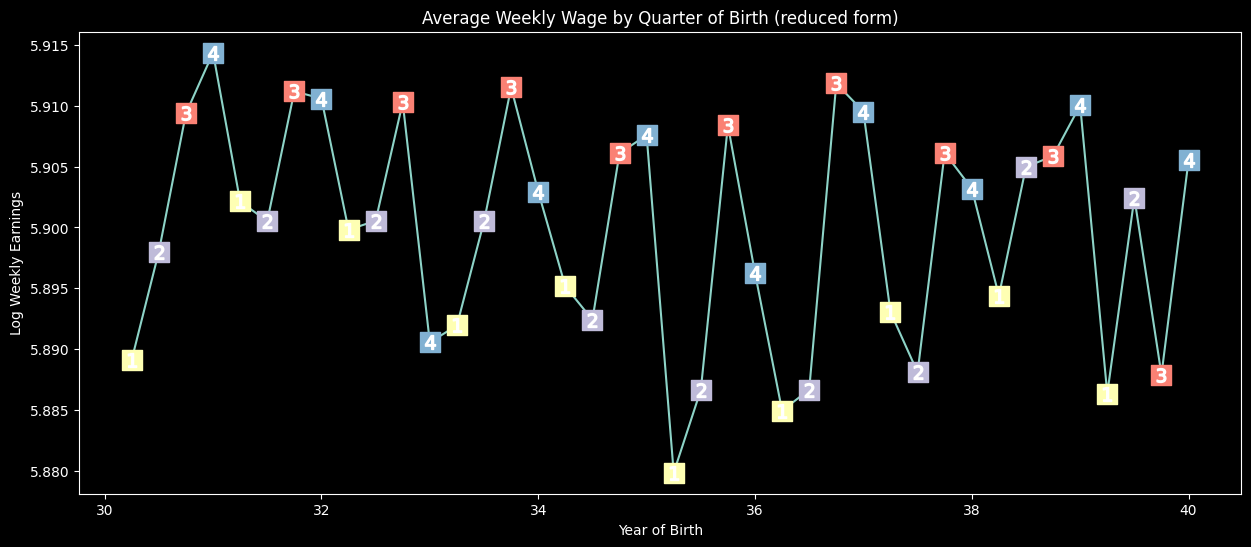

In [12]:
plt.figure(figsize=(15,6))
plt.plot(group_data["time_of_birth"], group_data["log_wage"], zorder=-1)
for q in range(1, 5):
    x = group_data.query(f"quarter_of_birth=={q}")["time_of_birth"]
    y = group_data.query(f"quarter_of_birth=={q}")["log_wage"]
    plt.scatter(x, y, marker="s", s=200, c=f"C{q}")
    plt.scatter(x, y, marker=f"${q}$", s=100, c=f"white")

plt.title("Average Weekly Wage by Quarter of Birth (reduced form)")
plt.xlabel("Year of Birth")
plt.ylabel("Log Weekly Earnings");

In [13]:
reduced_form = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + q4", data=factor_data).fit()

print("q4 parameter estimate:, ", reduced_form.params["q4"])
print("q4 p-value:, ", reduced_form.pvalues["q4"])

q4 parameter estimate:,  0.008603484260150222
q4 p-value:,  0.0014949127183463064


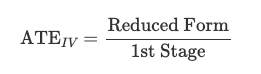

In [14]:
reduced_form.params["q4"] / first_stage.params["q4"]

0.08530286492096699

## Alternatively, 2 stage least squares

1. First stage
2. Replace treatment with fitted from first stage 

In [15]:
iv_by_hand = smf.ols("log_wage ~ C(year_of_birth) + C(state_of_birth) + years_of_schooling_fitted",
                     data=factor_data.assign(years_of_schooling_fitted=first_stage.fittedvalues)).fit()

iv_by_hand.params["years_of_schooling_fitted"]

0.08530286491916472

## Alternativlely with linearmodelsm

In [16]:
def parse(model, exog="years_of_schooling"):
    """
    Keep syntax same as statsmodels 
    """
    param = model.params[exog]
    se = model.std_errors[exog]
    p_val = model.pvalues[exog]
    print(f"Parameter: {param}")
    print(f"SE: {se}")
    print(f"95 CI: {(-1.96*se,1.96*se) + param}")
    print(f"P-value: {p_val}")
    
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q4]'
iv2sls = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv2sls)

Parameter: 0.0853028649457114
SE: 0.02554081281442268
95 CI: [0.03524287 0.13536286]
P-value: 0.0008381914633797116


## Multiple intsruments... every quarter

In [17]:
formula = 'log_wage ~ 1 + C(year_of_birth) + C(state_of_birth) + [years_of_schooling ~ q1+q2+q3]'
iv_many_zs = IV2SLS.from_formula(formula, factor_data).fit()
parse(iv_many_zs)

Parameter: 0.10769370486354657
SE: 0.019557149008424875
95 CI: [0.06936169 0.14602572]
P-value: 3.657974700921329e-08


In [18]:
# Compared to ols (no instrument)
formula = "log_wage ~ years_of_schooling + C(state_of_birth) + C(year_of_birth) + C(quarter_of_birth)"
ols = IV2SLS.from_formula(formula, data=data).fit()
parse(ols)

Parameter: 0.06732572817657179
SE: 0.0003883998439048556
95 CI: [0.06656446 0.06808699]
P-value: 0.0


2SLS has larger confidence interval

# Weakness of instruments 

- bias increase with number of instruments
- 